Projet 5 - Segmentez des clients d'un site e-commerce - Cleaning  
Classification non-supervisée selon 3 critères:
- #commandes/client
- durée écoulée depuis sa dernière commande
- somme totale dépensée

Puis choix d'initiative à prendre pour chaque classe obtenue.  
Enfin, raisonnement sur fréquence de màj de cette classification.  

- kmeans
- dbscan
- agglomerative clustering/hiérarchique statquest les décrit bien

 Commencer avec uniquement
Recency, Frequency, Monetary
car algos de clustering lourds (donc virer zipcode)
"subsampling"

>-
# 1. Initialisation, visualization

>>-
## 11. Imports

>>>-
### 111. Package imports

In [2]:
import numpy as np              # fast thus always used
import pandas as pd             # fast
pd.set_option("display.max_rows", 20, "display.max_columns", None)
import matplotlib.pyplot as plt # slow: 233 ns
import seaborn as sns           # SLOW BUT: 80.4 ns
sns.set_style("whitegrid")      # "ticks", "white"
import re
import my
import datetime
from scipy import interpolate   # FAST BUT: 319 ns ± 2.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
#  %timeit import geopandas     # SLOW 
#import os
#import sys
from IPython.display import clear_output
import warnings

>>>-
### 112. Data imports

In [5]:
dfs1 = pd.read_csv("olist_customers_dataset.csv") #, sep="\t")
dfs2 = pd.read_csv("olist_geolocation_dataset.csv") #, sep="\t")
dfs3 = pd.read_csv("olist_order_items_dataset.csv") #, sep="\t")
dfs4 = pd.read_csv("olist_order_payments_dataset.csv") #, sep="\t")
dfs5 = pd.read_csv("olist_order_reviews_dataset.csv") #, sep="\t")
dfs6 = pd.read_csv("olist_orders_dataset.csv") #, sep="\t")
dfs7 = pd.read_csv("olist_products_dataset.csv") #, sep="\t")
dfs8 = pd.read_csv("olist_sellers_dataset.csv") #, sep="\t")
dfs9 = pd.read_csv('product_category_name_translation.csv') #, sep='\t')
dfs = [dfs1, dfs2, dfs3, dfs4, dfs5, dfs6, dfs7, dfs8, dfs9]

>>-
## 12. Mise en forme du df

In [6]:
pd.set_option("display.max_rows", 20, "display.max_columns", None)
for df in dfs:
    display(df.shape)
    #print(list(df.columns))
    display(df.head())

(99441, 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


(1000163, 5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


(112650, 7)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


(103886, 5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


(99224, 7)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


(99441, 8)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


(32951, 9)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


(3095, 4)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


(71, 2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


- dfs1 me permettra de remonter au customer unique id à partir du customer id des autres tableaux donc je le garde. J'en retirerai peut-être les données géographiques si elles ont une feature importance basse.
- dfs2 donne juste d'autres façons de traduire les données géographiques. Il ne me servira pas.
- dfs3 donne une date, un prix et un prix de livraison pour chaque commande. Je le garde.
- dfs4 donne le prix de chaque commande. Est-ce redondant avec dfs3 ? À voir.
- dfs5 donne pour chaque commande la note/commentaire laissé par le client. Peut-être que je pourrai m'en servir juste pour savoir pour chaque client le taux de commandes qu'il a notées et que ça aiderait la classification mais j'y crois peu donc je retire ce tableau.
- dfs6 donne la correspondance entre customer id et order id. Il donne aussi la date d'achat, qui devrait être importante. Date redondante avec dfs3 ?
- dfs7 donne des infos sur les produits. Inutile.
- dfs8 donne les données géographiques du vendeur. Inutile.
- dfs9 est une traduction ES-EN de données inutiles.

In [7]:
dfs1.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


>>>-
### 121. Problèmes de merge

In [8]:
df = dfs1.merge(dfs6, on="customer_id", how="outer")
df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00


In [9]:
df = df.merge(dfs3, on="order_id", how="outer")
df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48


In [10]:
df = df.merge(dfs4, on="order_id", how="outer")
df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1.0,credit_card,8.0,335.48


In [11]:
#df = df[df["order_status"] == "delivered"]
#my.resindx(df)
#drops = ["customer_id","customer_city","customer_state","order_id","order_status","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date","order_item_id","product_id","]
keeps = ["customer_unique_id","order_purchase_timestamp","payment_value"]
#for i in drops:
#    df.drop(i, axis=1)
df = df[keeps]

In [11]:
df.head(2)

,customer_unique_id,order_purchase_timestamp,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48


In [18]:
df[df[["customer_unique_id","payment_value"]].duplicated(keep=False) == True]

,customer_unique_id,order_purchase_timestamp,payment_value
22,a96d5cfa0d3181817e2b946f921ea021,2017-10-15 11:08:48,232.71
23,a96d5cfa0d3181817e2b946f921ea021,2017-10-15 11:08:48,232.71
24,a96d5cfa0d3181817e2b946f921ea021,2017-10-15 11:08:48,232.71
36,e079b18794454de9d2be5c12b4392294,2017-06-14 18:31:54,134.25
37,e079b18794454de9d2be5c12b4392294,2017-06-14 18:31:54,134.25
...,...,...,...
118403,522e244a96d13876c5bac4985a8d5075,2018-01-30 15:28:21,662.34
118404,b96d6a178adbabf269fd843b37327798,2018-01-24 02:22:12,86.49
118405,b96d6a178adbabf269fd843b37327798,2018-01-24 02:22:12,1.51
118406,b96d6a178adbabf269fd843b37327798,2018-01-24 02:22:12,86.49


26249 ; Est-ce que j'ai créé des duplicatas pendant mon merge ou est-ce que ce sont juste des cas où le client a commandé plusieurs exemplaires du même item ?

In [23]:
dfs6[dfs6["order_purchase_timestamp"].duplicated(keep=False) == True].shape

(1122, 8)

En effet mon merge a l'air d'avoir créé des tonnes de duplicatas.

In [26]:
print("dfs1: " + str(dfs1.shape))
print("dfs6: " + str(dfs6.shape))
df = dfs1.head().merge(dfs6, on="customer_id", how="outer")
print("df  : " + str(df.shape))
print("dfs3: " + str(dfs3.shape))
df = df.merge(dfs3, on="order_id", how="outer")
print("df  : " + str(df.shape))
print("dfs4: " + str(dfs4.shape))
df = df.merge(dfs4, on="order_id", how="outer")
print("df  : " + str(df.shape))
df = df[keeps]
df.head(2)

dfs1: (99441, 5)
dfs6: (99441, 8)
df  : (99441, 12)
dfs3: (112650, 7)
df  : (113425, 18)
dfs4: (103886, 5)
df  : (118434, 22)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409.0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790.0,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1.0,credit_card,8.0,335.48


In [28]:
print("dfs1: " + str(dfs1.shape))
print("dfs6: " + str(dfs6.shape))
df = dfs1.iloc[:5,:].merge(dfs6, on="customer_id", how="outer")
print("df  : " + str(df.shape))
print("dfs3: " + str(dfs3.shape))
df = df.merge(dfs3, on="order_id", how="outer")
print("df  : " + str(df.shape))
print("dfs4: " + str(dfs4.shape))
df = df.merge(dfs4, on="order_id", how="outer")
print("df  : " + str(df.shape))
df = df[keeps]
df.head(2)

dfs1: (99441, 5)
dfs6: (99441, 8)
df  : (99441, 12)
dfs3: (112650, 7)
df  : (113425, 18)
dfs4: (103886, 5)
df  : (118434, 22)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409.0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790.0,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1.0,credit_card,8.0,335.48


Ça n'a pas l'air si dramatique mais il devrait quand même y avoir quelques doublons que je peux prévenir.
Je ne comprends pas pourquoi le head et le iloc sont ignorés.

In [29]:
print("dfs1: " + str(dfs1.shape))
print("dfs6: " + str(dfs6.shape))
df = dfs1[["customer_id","customer_unique_id"]].merge(dfs6[["customer_id","order_id","order_purchase_timestamp"]], on="customer_id", how="outer")
#print("df  : " + str(df.shape))
#print("dfs3: " + str(dfs3.shape))
#df = df.merge(dfs3[["order_id","price","freight_value"]], on="order_id", how="outer")
print("df  : " + str(df.shape))
print("dfs4: " + str(dfs4.shape))
df = df.merge(dfs4[["order_id","payment_value"]], on="order_id", how="outer")
print("df  : " + str(df.shape))
df = df[keeps]
df.head(2)

dfs1: (99441, 5)
dfs6: (99441, 8)
df  : (99441, 4)
dfs4: (103886, 5)
df  : (103887, 5)


,customer_unique_id,order_purchase_timestamp,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48


Là apparemment un seul doublon a été créé.
Donc la plupart des doublons viennent de ce que le merge voit dans les nombreuses colonnes inutiles au cours de son run.

>>>-
### 122. Merge propre

>>-
## 13. Visualisation

In [59]:
def hstplot(seris, strlog='log de ', hstsize=20):
    hst = seris.copy()
    hst.replace([np.inf, -np.inf], np.nan, inplace=True)
    hst.dropna(inplace=True)
    hst_val, hst_bin = np.histogram(hst, bins=50)
    hst = pd.DataFrame()
    hst.loc[:,'hst_bin'] = hst_bin[:-1] # Ou alors décaler d'un demi bin avec bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))].
    hst.loc[:,'hst_val'] = hst_val
    hst = hst[hst['hst_val'] != 0]
    with sns.axes_style("whitegrid"):
        sns.scatterplot(hst['hst_bin'], hst['hst_val'], legend=None, s=hstsize)
    plt.title(('Hist de ' + strlog + co),fontsize=16)
    plt.xlabel((strlog + co),fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
    plt.legend

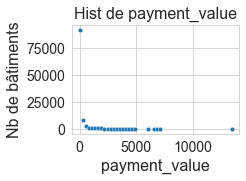

In [31]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(df["payment_value"], strlog='')
print()

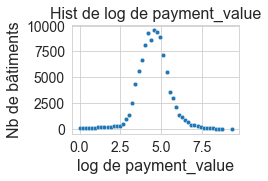

In [54]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(np.log(1+df["payment_value"]), strlog='log de ')
print()

Après le passage au log il n'y a aucun outlier.

In [66]:
df["log(p_v)"] = np.log(1+df["payment_value"])

In [55]:
%%script echo
t = datetime.datetime.strptime(df["order_purchase_timestamp"][0], "%Y-%m-%d %H:%M:%S") # %S.%f s'il y a les millièmes de seconde.
#int(t.strftime("%Y%m%d%H%M%S"))
(t - datetime.datetime(1970, 1, 1)).total_seconds() # epoch

Couldn't find program: 'echo'


In [56]:
def str_to_epoch(t_str):
    t = datetime.datetime.strptime(t_str, "%Y-%m-%d %H:%M:%S") # %S.%f s'il y a les millièmes de seconde.
    #int(t.strftime("%Y%m%d%H%M%S"))
    return (t - datetime.datetime(1970, 1, 1)).total_seconds() # epoch

In [63]:
def str_to_dttm(t_str):
    return datetime.datetime.strptime(t_str, "%Y-%m-%d %H:%M:%S") # %S.%f s'il y a les millièmes de seconde.

In [60]:
tt = pd.Series(name="purchase time")
for i in range(df.shape[0]):
    tt.loc[i] = str_to_epoch(df["order_purchase_timestamp"][i])

In [61]:
tt

0         1.494947e+09
1         1.515790e+09
2         1.526746e+09
3         1.520957e+09
4         1.532858e+09
              ...     
103882    1.523116e+09
103883    1.522830e+09
103884    1.523218e+09
103885    1.509743e+09
103886    1.513694e+09
Name: purchase time, Length: 103887, dtype: float64

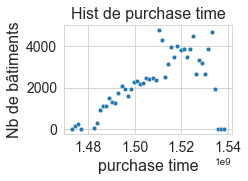

In [62]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(tt, strlog='')
print()

Ici non plus pas d'outlier.

In [67]:
df["p_t_epoch"] = tt

In [ ]:
r=

In [64]:
dttm = pd.Series(name="purchase time")
for i in range(df.shape[0]):
    dttm.loc[i] = str_to_dttm(df["order_purchase_timestamp"][i])

In [65]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dttm, strlog='')
print()

UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

<Figure size 216x144 with 0 Axes>

In [68]:
df.head()

,customer_unique_id,order_purchase_timestamp,payment_value,log(p_v),p_t_epoch
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87,4.996334,1.494947e+09
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48,5.818539,1.515790e+09
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,157.73,5.067205,1.526746e+09
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,173.30,5.160778,1.520957e+09
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,252.25,5.534377,1.532858e+09


>-
# 2. Cleaning

>>-
## 21. Missing values

In [69]:
df.isna().sum()

customer_unique_id          0
order_purchase_timestamp    0
payment_value               1
log(p_v)                    1
p_t_epoch                   0
dtype: int64

>>-
## 22. Imputation

In [70]:
df.loc[df["log(p_v)"].isna(),"log(p_v)"] = df["log(p_v)"].mean()

Là j'utilise le mean() car on a affaire à une distribution qui est quasiment une distribution normale.

In [71]:
df.to_csv('df1.csv')

>-
# 3. Classifications

Pipeline:
- OHE sur l'id
- regex/datetime du timestamp pour en faire une var num puis scaler
- scaler du prix
- estimateurs